In [41]:
import re
import gensim
import logging
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import KMeans
import collections
from heapq import nsmallest
import zipfile

import warnings
warnings.filterwarnings('ignore')


In [3]:
with open('vps.txt', 'r', encoding='utf-8') as f:
    text = f.readlines()


In [4]:
# returns a ist of verb phrases


def get_verb_phrases(text):
    verb_phrases = []
    for line in text:
        vp = re.search('(.+?)\t', line)
        if vp:
            verb_phrases.append(vp.group(1))
    return verb_phrases


In [5]:
verb_phrases = get_verb_phrases(text)


In [6]:
# 1, 2
# returns a list of verb phrase vectors


def get_vectors(text):
    vectors_list = []
    # downloading and extracting model
    # urllib.request.urlretrieve('http://vectors.nlpl.eu/repository/20/180.zip')
    # with zipfile.ZipFile('./', 'r') as zip_ref:
    #     zip_ref.extractall('./')
    # file 'model.bin' is in the same directory with the hw1.ipynb file
    m = 'model.bin'
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
    verb = re.search('([а-я]+?)_', text[0])
    if verb:
        v_query = verb.group(1) + '_VERB'
        if v_query in model:
            v_vec = model[v_query]
    for line in text:
        noun = re.search('_([а-я]+)', line)
        if noun:
            n_query = noun.group(1) + '_NOUN'
            if n_query in model:
                n_vec = model[n_query]
        vectors_list.append(v_vec + n_vec)
    return vectors_list


In [7]:
vectors = get_vectors(text)
matrix = np.array(vectors)


In [8]:
# 3.2
# this function returns a dictionary of cluster number: verb phrase vector
# only clusters with 2 or more elements are included in the dictionary


def get_clusters(clusters, matrix):
    clus = {}
    trimmed_clus = {}
    for i in range(len(clusters)):
        if clusters[i] not in clus.keys():
            clus[clusters[i]] = []
        clus[clusters[i]].append(matrix[i])
    for key, value in clus.items():
        if len(value) >= 2:
            trimmed_clus[key] = value
    return trimmed_clus


In [12]:
# let's find the optimum of clusters for hierarchic clustering
# increment t by 0.1 from 0 to 2

Z = hcluster.linkage(matrix)
N = np.linspace(0.0, 2.0, 21)
for n in N:
    hierarchic = hcluster.fcluster(Z, n)
    print('step:', n, len(set(hierarchic)))


step: 0.0 118
step: 0.1 118
step: 0.2 118
step: 0.30000000000000004 118
step: 0.4 118
step: 0.5 118
step: 0.6000000000000001 118
step: 0.7000000000000001 118
step: 0.8 85
step: 0.9 50
step: 1.0 1
step: 1.1 1
step: 1.2000000000000002 1
step: 1.3 1
step: 1.4000000000000001 1
step: 1.5 1
step: 1.6 1
step: 1.7000000000000002 1
step: 1.8 1
step: 1.9000000000000001 1
step: 2.0 1


Оптимальное значение t=0.9, при бОльших значених все фразы попадут в один огромный кластер, а при меньших будет слишком много кластеров. При 50 кластерах в каждом кластере будет хотя бы по 3 глагола в группе.

In [39]:
# 3.3
# hierarchic clustering

Z = hcluster.linkage(matrix)
hierarchic = hcluster.fcluster(Z, 0.9)
hierarchic_dict = get_clusters(hierarchic, matrix)


In [38]:
# let's find out what is an optimum k via the sum of squared distances

sd = []
K = range(1, 50)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(matrix)
    sd.append(kmeans.inertia_)


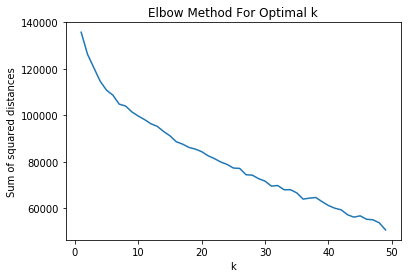

In [15]:
# drawing the curve

plt.plot(K, sd)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()


Для поиска оптимального значения порога я воспользовалась методом elbow. График становится более гладким после преодоления k=10.

In [36]:
# 3.4 kMeans clustering

kmeans = KMeans(n_clusters=10).fit(matrix)
kmeans_dict = get_clusters(kmeans.labels_, matrix)


In [24]:
# 4
# prints groups of three verb phrases which vectors belong to the same cluster
# cosine similarity is used as a measure of closeness


def get_center(clusters_dict, verb_phrases, vectors):
    v_index = []
    cos = []
    for key, value in clusters_dict.items():
        # calculating a mean through all vectors of a cluster
        mean = np.mean(value, axis=0)
        # for each vector we calculate a cosine similarity between a mean and a vector
        for v in value:
            cos_sim = 1 - spatial.distance.cosine(mean, v)
            cos.append(cos_sim)
            v_index.append(v)
        closest = nsmallest(3, cos)
        for c in closest:
            # index of a vector in v_index - which cos_sim belongs to which vector
            index = np.where(cos == c)[0][0]
            # found this vector
            vector = v_index[index]
            # now find the verb phrase based on a vector
            vp_index = np.where(vectors == vector)[0][0]
            print(verb_phrases[vp_index], end=', ')
        print('\r')


In [40]:
# 5

print('Clusters via hierarchic clustering:')
get_center(hierarchic_dict, verb_phrases, vectors)


Clusters via hierarchic clustering:
вести_наступление, вести_бой, вести_противник, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 
вести_аллея, вести_лестница, вести_дорога, 


Получившиеся группы довольно однородны: группа *вести наступление, вести бой, вести противник* связана с управлением и семантикой военных действий, а группа *вести аллея, вести лестница, вести дорога* - с направлением. Однако проиллюстрированы далеко не все значения глагола, более того, почти ко всем центрам кластеров оказались близки значения направления, что может объясняться распространенностью глагола *вести* в этом значении в модели.

In [37]:
print('Clusters via hierarchic clustering:')
get_center(kmeans_dict, verb_phrases, vectors)


Clusters via hierarchic clustering:
вести_умение, вести_роль, вести_кружок, 
вести_умение, вести_роль, вести_кружок, 
вести_умение, вести_роль, вести_кружок, 
вести_умение, вести_роль, вести_кружок, 
вести_год, вести_день, вести_след, 
вести_рука, вести_год, вести_день, 
вести_рука, вести_год, вести_день, 
вести_рука, вести_год, вести_день, 
вести_рука, вести_год, вести_день, 
вести_рука, вести_год, вести_день, 


Первая группа словосочетаний также иллюстрирует значение руководства глагола *вести* с семантикой образования. Далее идет кластер со значением *осуществлять*. Не думаю, что этим исчерпаны все значения многозначного глагола, однако возможно это особенность модели.
В целом разные методы кластаризации показали различные, хотя местами схожие результаты. 